**Import detector demand from mycity data**

In the folder input there are files from Landau intersections

**Proof of Concept**

In [11]:
folder = 'input/landau/LD-LSA1'

In [12]:
import os
import json

def find_json_files(directory, start_date, end_date):
    """
    Finds all JSON files in the given directory within a specified date range.

    Args:
        directory: The path to the directory to search.
        start_date: The start date in "YYYY-MM-DD" format (e.g., "2025-01-01").
        end_date: The end date in "YYYY-MM-DD" format (e.g., "2025-06-30").

    Returns:
        A list of file paths to the JSON files within the date range.
    """
    files = []
    for filename in os.listdir(directory):
        if filename.startswith("2025-") and filename.endswith(".json"):

            try:
               
                file_date = filename[5:-5]
                year = "2025"  # Add the year explicitly
                month, day = map(int, file_date.split("-"))
                file_date = f"{year}-{month:02}-{day:02}"  # Construct the full date string

                # Corrected comparison - moved the comparison to the if statement
                if start_date <= file_date <= end_date:
                    filepath = os.path.join(directory, filename)
                    # You can add code here to process the JSON file
                    # Example:
                    # with open(filepath, 'r') as f:
                    #     data = json.load(f)
                    #     print(f"File: {filepath}, Data: {data}")
                    files.append(filepath)
            except ValueError:
                print(f"Invalid date format in file: {filename}")
                pass
    return files

In [13]:
# Example Usage:
start_date = "2025-06-01"
end_date = "2025-06-24"

json_files = find_json_files(folder, start_date, end_date)

**Parse first file and understand the content**

In [14]:
import json
from collections import defaultdict

file = json_files[0] #first file for testing
with open(file, 'r') as f:  
    data = json.load(f)     

# detector_id -> total demand
demand_per_detector = defaultdict(int)

demandValues = []
for timeframe in data["timeFrames"]:
    demand = 0
    for detector in timeframe["detectors"]:
        detector_id = detector["id"]
        if detector_id == 7:
            demand = detector["reading"]["count"]["value"]
    demandValues.append(demand)

print(demandValues)


[4, 2, 5, 2, 3, 3, 0, 1, 1, 5, 2, 2, 2, 0, 1, 6, 3, 8, 8, 5, 7, 12, 5, 9, 8, 11, 12, 12, 11, 15, 22, 25, 29, 27, 23, 26, 39, 28, 21, 36, 33, 43, 39, 37, 40, 37, 30, 35, 32, 41, 40, 35, 40, 34, 28, 34, 28, 33, 25, 147, 41, 40, 46, 46, 39, 40, 36, 37, 32, 23, 28, 29, 29, 19, 28, 24, 19, 23, 14, 19, 10, 14, 14, 10, 6, 8, 5, 2, 2, 2, 3, 3, 2, 0, 2, 1]


**Show demand for Detector D11 / LSA1**

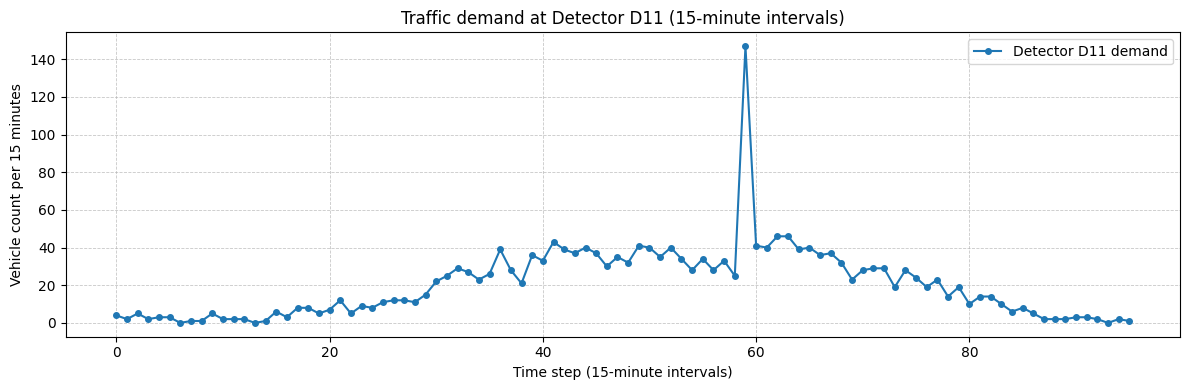

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# demandValues:
# 15-minute aggregated vehicle counts from detector D11
# Example: each value = vehicles counted in one 15-min interval

# Create time axis (x-axis)
time_steps = np.arange(len(demandValues))

plt.figure(figsize=(12, 4))

# Plot demand time series
plt.plot(
    time_steps,
    demandValues,
    marker='o',
    linestyle='-',
    linewidth=1.5,
    markersize=4,
    label="Detector D11 demand"
)

# Title and labels
plt.title("Traffic demand at Detector D11 (15-minute intervals)")
plt.xlabel("Time step (15-minute intervals)")
plt.ylabel("Vehicle count per 15 minutes")

# Improve x-axis readability
# Show ticks every 20 steps = every 5 hours (20 × 15 min)
plt.xticks(
    ticks=np.arange(0, len(time_steps), 20),
    labels=np.arange(0, len(time_steps), 20)
)

# Grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()


**Read all vectortors from Detector D11 / LSA1 for all days**

In [16]:
import json

detector_id_target = 7  # D11
all_demand_values = []  # <- ALL DAYS, ONE VECTOR

for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)

    for timeframe in data["timeFrames"]:
        demand = 0  # default if detector not found

        for detector in timeframe["detectors"]:
            if detector["id"] == detector_id_target:
                demand = detector["reading"]["count"]["value"]
                break

        all_demand_values.append(demand)

print("Total 15-minute intervals:", len(all_demand_values))
print(all_demand_values[:20])  # first 20 values


Total 15-minute intervals: 2249
[4, 2, 5, 2, 3, 3, 0, 1, 1, 5, 2, 2, 2, 0, 1, 6, 3, 8, 8, 5]


**Demand Plot for 23 Days**

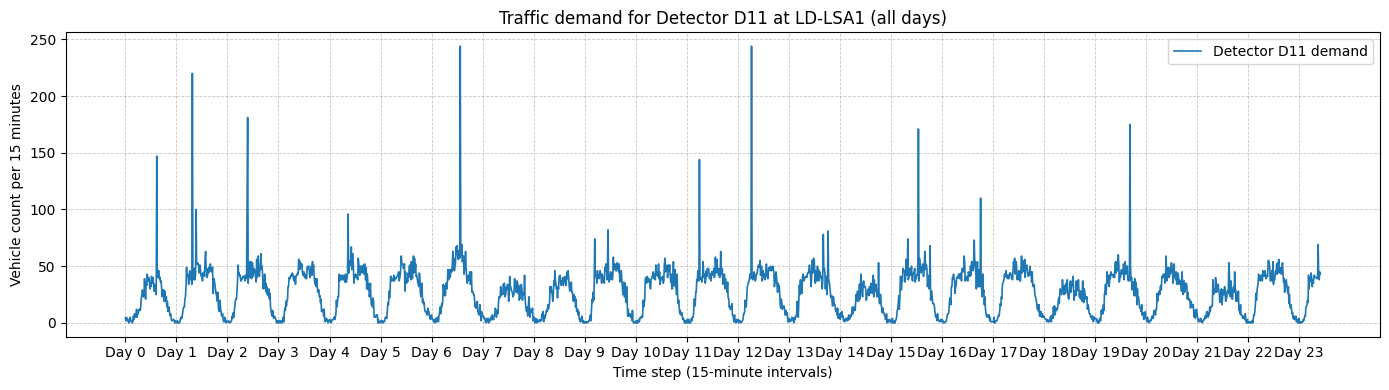

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# all_demand_values:
# Concatenated traffic demand values from Detector D11
# Each value represents vehicle count aggregated over 15 minutes
# Data spans multiple consecutive days

plt.figure(figsize=(14, 4))

# Time axis: index of 15-minute intervals
time_steps = np.arange(len(all_demand_values))

plt.plot(
    time_steps,
    all_demand_values,
    linewidth=1.2,
    label="Detector D11 demand"
)

# Titles and labels
plt.title("Traffic demand for Detector D11 at LD-LSA1 (all days)")
plt.xlabel("Time step (15-minute intervals)")
plt.ylabel("Vehicle count per 15 minutes")

# Improve x-axis readability:
# Show one tick per day (96 intervals = 24 hours)
plt.xticks(
    ticks=np.arange(0, len(time_steps), 96),
    labels=[f"Day {i}" for i in range(len(time_steps) // 96 + 1)]
)

# Grid for readability
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()


**Outliers Cleaning - Percentile-Based outlier clipping-**

In [20]:
import numpy as np

# Python list -> numpy array
series = np.array(all_demand_values, dtype=float)

# determine the upper limit (99. percentile)
upper_limit = np.percentile(series, 99)

print("Upper clipping limit:", upper_limit)

# Outlier clipping
series_clean = np.clip(series, 0, upper_limit)

#Extreme outliers caused by detector malfunctions were filtered using a percentile-based clipping approach. 
# Values above the 99th percentile were capped to preserve the temporal structure of the traffic 
# demand time series while removing unrealistic spikes.



Upper clipping limit: 67.0


**Normalization**

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

series = series_clean.reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

print(series_scaled[:10])


[[0.05970149]
 [0.02985075]
 [0.07462687]
 [0.02985075]
 [0.04477612]
 [0.04477612]
 [0.        ]
 [0.01492537]
 [0.01492537]
 [0.07462687]]


**Sliding Window**

In [22]:
import numpy as np

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 8
X, y = create_sequences(series_scaled, lookback)

print("X shape:", X.shape)
print("y shape:", y.shape)

#N : Samples
#8 : Look Back (Time Steps)
#1 : Number of Features (One Dedector)

print(X[0].flatten())
print("Target:", y[0])



X shape: (2241, 8, 1)
y shape: (2241, 1)
[0.05970149 0.02985075 0.07462687 0.02985075 0.04477612 0.04477612
 0.         0.01492537]
Target: [0.01492537]


**Converting tensor to torch, since I could not download the tensorflow bib**

In [23]:
import torch

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print(X_tensor.shape, y_tensor.shape)


torch.Size([2241, 8, 1]) torch.Size([2241, 1])


**Train / Test Split STEP1**

In [24]:
split = int(0.8 * len(X_tensor))

X_train = X_tensor[:split]
X_test  = X_tensor[split:]

y_train = y_tensor[:split]
y_test  = y_tensor[split:]


**Building LSTM MODEL**

*Data Loader*

In [25]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=False  # time series -> no shuffle
)


**LSTM + OSS+ OPTIMIZER**

In [26]:
import torch.nn as nn
import torch

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]      # last time step
        out = self.fc(out)
        return out

model = LSTMModel(input_size=1, hidden_size=32)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


**Train Loop**

In [27]:
epochs = 30

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_loader.dataset)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train MSE: {epoch_loss:.6f}")


Epoch 5/30 - Train MSE: 0.015243
Epoch 10/30 - Train MSE: 0.012674
Epoch 15/30 - Train MSE: 0.010356
Epoch 20/30 - Train MSE: 0.009721
Epoch 25/30 - Train MSE: 0.009339
Epoch 30/30 - Train MSE: 0.009124


**Test Prediction + Inverse Scale + MAR/RMSE + Graphic**

MAE (vehicles/15min): 4.073
RMSE (vehicles/15min): 5.882


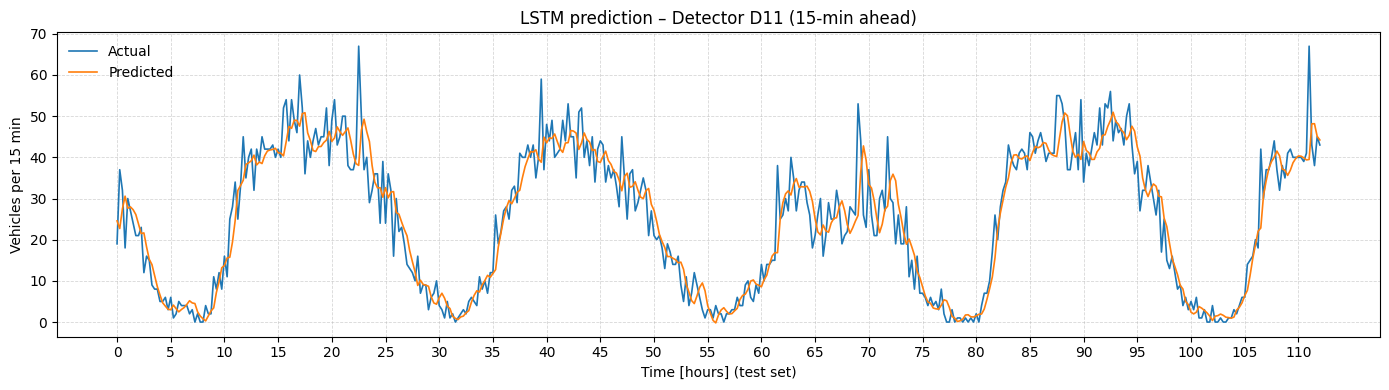

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Predict on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 2) Torch -> numpy
y_test_np = y_test.detach().cpu().numpy()
y_pred_np = y_pred.detach().cpu().numpy()

# 3) Inverse transform back to vehicle counts
y_test_inv = scaler.inverse_transform(y_test_np).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_np).flatten()

# 4) Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE (vehicles/15min): {mae:.3f}")
print(f"RMSE (vehicles/15min): {rmse:.3f}")

# 5) Plot: Actual vs Predicted (clean & readable)
plt.figure(figsize=(14, 4))

# x-axis in hours (1 step = 15 min)
t = np.arange(len(y_test_inv))
t_hours = t * 15 / 60

plt.plot(t_hours, y_test_inv, linewidth=1.2, label="Actual")
plt.plot(t_hours, y_pred_inv, linewidth=1.2, label="Predicted")

plt.title("LSTM prediction – Detector D11 (15-min ahead)")
plt.xlabel("Time [hours] (test set)")
plt.ylabel("Vehicles per 15 min")

# Minimal grid (less visual noise)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.5)

# Fewer ticks (every 5 hours)
max_h = int(t_hours[-1])
plt.xticks(np.arange(0, max_h + 1, 5))

plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.show()


**Train LSTM for different time horizons**

In [30]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1) Prepare scaled series ONCE (use your cleaned series) ---
series = np.array(series_clean, dtype=float).reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# --- 2) Sequence builder with horizon ---
def create_sequences_horizon(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - (horizon - 1)):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback + (horizon - 1)])
    return np.array(X), np.array(y)

# --- 3) PyTorch LSTM model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]      # last time step
        out = self.fc(out)
        return out

def train_and_eval_for_horizon(horizon, lookback=8, epochs=30, batch_size=32, lr=0.001):
    # Build X,y for this horizon
    X, y = create_sequences_horizon(series_scaled, lookback, horizon)

    # Tensorize
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Time-ordered split
    split = int(0.8 * len(X_tensor))
    X_train, X_test = X_tensor[:split], X_tensor[split:]
    y_train, y_test = y_tensor[:split], y_tensor[split:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)

    # Model
    model = LSTMModel(input_size=1, hidden_size=32)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    # Predict
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    # Inverse transform
    y_test_np = y_test.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    y_test_inv = scaler.inverse_transform(y_test_np)
    y_pred_inv = scaler.inverse_transform(y_pred_np)

    # Metrics
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    return mae, rmse

# --- 4) Run for multiple horizons --
horizons = [1, 2, 4]  # 15, 30, 60 minutes ahead
results = []

for h in horizons:
    mae, rmse = train_and_eval_for_horizon(horizon=h, lookback=8, epochs=30)
    results.append((h, 15*h, mae, rmse))
    print(f"Horizon={h} ({15*h} min ahead) -> MAE={mae:.3f}, RMSE={rmse:.3f}")

print("\n=== Summary ===")
for h, minutes, mae, rmse in results:
    print(f"{minutes:>3} min ahead | MAE={mae:.3f} | RMSE={rmse:.3f}")


Horizon=1 (15 min ahead) -> MAE=4.092, RMSE=5.890
Horizon=2 (30 min ahead) -> MAE=4.451, RMSE=6.225
Horizon=4 (60 min ahead) -> MAE=5.352, RMSE=7.179

=== Summary ===
 15 min ahead | MAE=4.092 | RMSE=5.890
 30 min ahead | MAE=4.451 | RMSE=6.225
 60 min ahead | MAE=5.352 | RMSE=7.179


**Horizon-Error Graph**

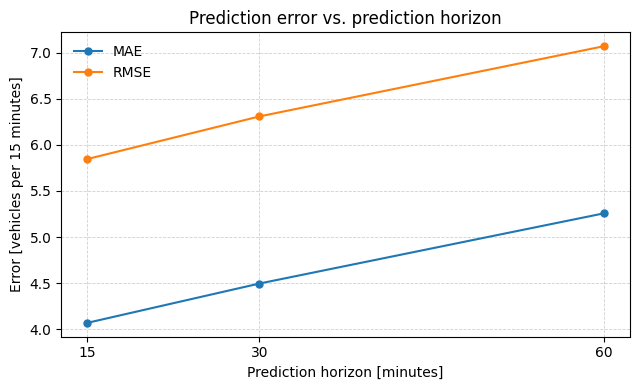

In [31]:
import matplotlib.pyplot as plt
import numpy as np

horizons_min = np.array([15, 30, 60])
mae_vals = np.array([4.069, 4.496, 5.258])
rmse_vals = np.array([5.846, 6.309, 7.071])

plt.figure(figsize=(6.5, 4))

plt.plot(
    horizons_min,
    mae_vals,
    marker='o',
    linewidth=1.5,
    markersize=5,
    label="MAE"
)

plt.plot(
    horizons_min,
    rmse_vals,
    marker='o',
    linewidth=1.5,
    markersize=5,
    label="RMSE"
)

plt.xlabel("Prediction horizon [minutes]")
plt.ylabel("Error [vehicles per 15 minutes]")
plt.title("Prediction error vs. prediction horizon")

# Clean grid (major only)
plt.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.6)

# Explicit x-ticks (avoid interpolation confusion)
plt.xticks(horizons_min)

plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.show()
